In [1]:
import numpy as np
import rasterio

combined_file_path = "../datasets/output.tif"
with rasterio.open(combined_file_path) as src:
    print(src.meta)
    width = src.meta['width']
    height = src.meta['height']
    channels = src.meta['count']
    # 分块保存ndarray，每块大小为 256 * 256
    block_size = 256
    for i in range(0, height, block_size // 2):
        for j in range(0, width, block_size // 2):
            block = src.read(window=(
                (i, min(i + block_size, height)),
                (j, min(j + block_size, width)))
            )
            
            if block.shape[1:] != (block_size, block_size):
                pad_height = block_size - block.shape[1]
                pad_width = block_size - block.shape[2]
                block = np.pad(block, ((0, 0), (0, pad_height), (0, pad_width)), mode='constant')
            
            # 保存 block 数组
            np.save(f'../dataV2/infer/blocks/block_{i}_{j}.npy', block)
            # break
    # data = src.read()
    # 保存 data 数组
    # np.save('data.npy', data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 37677, 'height': 35068, 'count': 5, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]'), 'transform': Affine(0.0626, 0.0, 264493.5783968877,
       0.0, -0.0626, 4512247.584260046)}


In [1]:
from SegmentationDatasetV2 import SegmentationDatasetV2, ROOT
import os

images_dir = os.path.join(ROOT, 'dataV2', 'infer')

infer_dataset = SegmentationDatasetV2(root_dir=images_dir, inference=True)

In [2]:
import re
import numpy as np

images = infer_dataset.get_arrays()
max_x = 0
max_y = 0

for image in images:
    match = re.search(r'_(\d+)_(\d+)\.npy', image)
    if match:
        x = int(match.group(1))
        y = int(match.group(2))
        if x > max_x:
            max_x = x
        if y > max_y:
            max_y = y

# 新建一个 ndarray
array = np.zeros((3, max_x + 256, max_y + 256), dtype=np.float16)
array.shape

(3, 35200, 37888)

In [3]:
from torch import nn
from tif2pngs import ROOT
import os
from segmentation_models_pytorch import Unet
import torch

model_path = os.path.join(ROOT, 'model', 'best_model_epoch_50_5c.pth')
model_config = {
    'model': Unet,
    'encoder_name': 'resnet34',
    'classes': 3,
    'channels': 5,
    'activation': 'softmax',
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model_config['model'](
    encoder_name=model_config['encoder_name'],
    classes=model_config['classes'],
    in_channels=model_config['channels'],
    activation=model_config['activation'],
).to(device)

model=nn.DataParallel(model)

model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
pass

In [4]:
from tqdm.notebook import tqdm
import numpy as np
import re

with torch.no_grad():
    with tqdm(total=len(images)) as pbar:
        for input_image, image_name in infer_dataset:
            tmp = torch.tensor(input_image).unsqueeze(0).to(device)
            output = model(tmp)
            result = output.squeeze().cpu().numpy()
            # print(result.shape)
            # print(image_name)
            match = re.search(r'_(\d+)_(\d+)', image_name)
            if match:
                x = int(match.group(1))
                y = int(match.group(2))
                array[:, x:x + 256, y:y + 256] += result
            else:
                print(f"Error: {image_name} does not match the pattern")
                
            pbar.update(1)
            # break

  0%|          | 0/80830 [00:00<?, ?it/s]

E:\DataMining\corn-anomaly-detection\venv\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [5]:
# 保存 array 到 npy 文件
import time
file_name = f"submission_{int(time.time())}.npy"
np.save(file_name, array)
file_name

'submission_1732181751.npy'

In [1]:
import rasterio
import os
from tif2pngs import ROOT
result_file_path = os.path.join(ROOT, 'datasets', 'B', 'result.tif')
with rasterio.open(result_file_path) as src:
    meta = src.meta.copy()
    print(meta)
    pruned_shape = (meta['height'], meta['width'])


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 37677, 'height': 35068, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]'), 'transform': Affine(0.0626, 0.0, 264493.5783968877,
       0.0, -0.0626, 4512247.584260046)}


In [2]:
meta.update({
    'count': 1,
})

In [3]:
import numpy as np
# 从 npy 文件获取矩阵
array = np.load(f"submission_1732181751.npy")

In [4]:
array.shape

(3, 35200, 37888)

In [5]:
pruned_shape

(35068, 37677)

In [6]:
array = np.argmax(array, axis=0)

In [7]:
array.shape

(35200, 37888)

In [8]:
# 将 array 裁剪到与 result.tif 相同的大小
array = array[:pruned_shape[0], :pruned_shape[1]]

In [9]:
array.shape

(35068, 37677)

In [10]:
import time
import rasterio
import os
from tif2pngs import ROOT
output_path = os.path.join(ROOT, f'submission_{int(time.time())}.tif')

with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(array, 1)


In [11]:
# 统计 array 中每个值的出现次数
counts = np.bincount(array.flatten())
print(counts)

[1022370855  297452646    1433535]


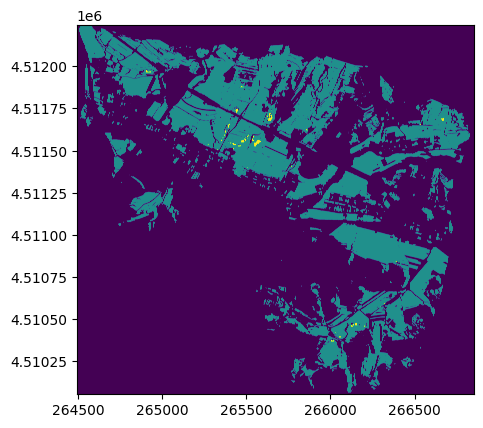

<Axes: >

In [8]:
from rasterio.plot import show

# 打开tif文件
ds_standard = rasterio.open(output_path)

show((ds_standard, 1))

In [11]:
import numpy as np

# 创建一个float16类型的数组
arr_float16 = np.array([1.0], dtype=np.float16)

# 创建一个float32类型的值
value_float32 = np.float32(1.123456789)

# 将float32类型的值赋给float16类型的数组
arr_float16[0] = value_float32

# 输出转换后的数组
print(arr_float16)
print(arr_float16.dtype)


[1.123]
float16


In [12]:
# 用 raster.io 读取两份 tif 提交文件，获得两个 ndarray；取矩阵中每个元素的较大值。由于文件较大，需要分块操作

submission_1 = os.path.join(ROOT, 'submission_1732181983.tif')
submission_2 = os.path.join(ROOT, 'submission_1732186329.tif')

with rasterio.open(submission_1) as src1, rasterio.open(submission_2) as src2:
    meta = src1.meta.copy()
    meta.update(count=1)
    # 读取两个文件的数据
    data1 = src1.read(1)
    data2 = src2.read(1)
    # 取两个矩阵中每个元素的较大值
    result = np.maximum(data1, data2)
    # 将结果保存为新的tif文件
    with rasterio.open(os.path.join(ROOT, 'submission_combined.tif'), 'w', **meta) as dst:
        dst.write(result, 1)